# Simulated annealing - Caixeiro Viajante
## Luís Felipe Ramos Ferreira - 2019022553

In [145]:
import numpy as np
import numpy.typing as npt
import scipy
import matplotlib.pyplot as plt
from numba import jit
import networkx as nx

In [146]:
def generate_random_graph(number_of_nodes: np.int_) -> npt.NDArray[np.float_]:
    nodes: npt.NDArray[np.float_] = np.random.rand(number_of_nodes, 2)
    adjacency_matrix: npt.NDArray[np.float_] = scipy.spatial.distance_matrix(nodes, nodes)
    return adjacency_matrix, nodes

""" @jit(nopython=True)
def crossed_river(city_1_x: np.float_, city_2_x: np.float_) -> bool:
    return (city_1_x < 0.5 and city_2_x > 0.5) or (city_1_x > 0.5 and city_2_x < 0.5) """

def plot_path(nodes: npt.NDArray[np.float_], path: npt.NDArray[np.int_], path_cost: np.float_) -> None:
    plt.figure(figsize=(4, 4))
    plt.title(f"Custo do caminho: {path_cost}")
    plt.scatter(nodes[:, 0], nodes[:,1], c="black")
    for i in range(path.shape[0] - 1):
        x_coordinates: npt.NDArray[np.float_] = np.array([nodes[path[i]][0], nodes[path[i + 1]][0]])
        y_coordinates: npt.NDArray[np.float_] = np.array([nodes[path[i]][1], nodes[path[i + 1]][1]])
        plt.plot(x_coordinates, y_coordinates, "b-")
    plt.show()

def plot_distance_temperature(distances: npt.NDArray[np.float_], temperatures: npt.NDArray[np.float_], number_of_cities: np.float_, initial_temperature: np.float_, delta_t: np.float_, temperature_inferior_limit: np.float_) -> None:
    _, ax1 = plt.subplots(figsize = (6, 4))
    ax1.plot(distances, color="blue")
    ax1.set_ylabel("Distância percorrida no caminho escolhido", color="blue")
    ax1.set_xlabel("Passos de Monte Carlo")

    ax2 = ax1.twinx()
    ax2.plot(temperatures, color="red")
    ax2.set_ylabel("Temperatura", color="red")
    
    plt.title(f"Número de cidades: {number_of_cities}, Temperatura inicial: {initial_temperature}\n Delta T: {delta_t}, Limite inferior de temperatura: {temperature_inferior_limit}")
    plt.show()

In [147]:
@jit(nopython=True)
def performe_monte_carlo_steps(number_of_monte_carlo_steps: np.int_, number_of_cities: np.int_, temperature: np.float_, graph: npt.NDArray[np.float_], nodes: npt.NDArray[np.float_], current_path: npt.NDArray[np.int_], current_path_cost: np.float_) -> np.float_:
    for _ in range(number_of_monte_carlo_steps):
        for _ in range(number_of_cities):
            proposed_x, proposed_y = np.sort(np.random.choice(np.arange(number_of_cities), size=2, replace=False))
            current_path = np.roll(current_path, shift=1)
            proposed_path: npt.NDArray[np.int_] = current_path.copy()
            proposed_path[proposed_x + 1: proposed_y] = np.flip(proposed_path[proposed_x + 1: proposed_y])

            remove_edge_1_cost: np.float_ = graph[current_path[proposed_x]][current_path[(proposed_x + 1) % number_of_cities]]
            remove_edge_2_cost: np.float_ = graph[current_path[proposed_y - 1]][current_path[proposed_y]]
            add_edge_1_cost: np.float_ = graph[proposed_path[proposed_x]][proposed_path[(proposed_x + 1) % number_of_cities]]
            add_edge_2_cost: np.float_ = graph[proposed_path[proposed_y - 1]][proposed_path[proposed_y]]

            decrease: np.float_ = remove_edge_1_cost + remove_edge_2_cost
            increase: np.float_ = add_edge_1_cost + add_edge_2_cost
            proposed_path_cost: np.float_ = current_path_cost - decrease + increase
            delta: np.float_ = proposed_path_cost - current_path_cost
            r: np.float_ = np.random.rand()
            P: np.float_ = np.exp(-1 * delta / temperature)
            if delta < 0 or r <= P:
                current_path = proposed_path.copy()
                current_path_cost = proposed_path_cost
    return current_path, current_path_cost

In [8]:
def tsp(graph: npt.NDArray[np.float_], nodes: npt.NDArray[np.float_], temperature: np.float_, delta_t: np.float_, temperature_inferior_limit: np.float_) -> tuple:
    number_of_monte_carlo_steps: np.int_ = 1 # hard coded
    number_of_cities: np.int_ = graph.shape[0]
    current_path: npt.NDArray[np.int_] = np.arange(number_of_cities)
    np.random.shuffle(current_path)
    edges: npt.NDArray[np.int_] = np.append(np.lib.stride_tricks.sliding_window_view(current_path, 2), [[current_path[-1], current_path[0]]], axis=0)
    current_path_cost: np.float_ = np.sum([graph[i, j] for i, j in edges])
    
    temperatures: list[float] = []
    distances: list[float] = []

    while temperature > temperature_inferior_limit:
        temperatures.append(temperature)
        distances.append(current_path_cost)
        current_path, current_path_cost = performe_monte_carlo_steps(number_of_monte_carlo_steps=number_of_monte_carlo_steps, number_of_cities=number_of_cities, temperature=temperature, graph=graph, nodes=nodes, current_path=current_path, current_path_cost=current_path_cost)
        temperature *= delta_t

    current_path = np.append(current_path, current_path[0])
    return current_path, current_path_cost, nodes, distances, temperatures

# Análise dos resultados

Para analisar as implementações e os resultados da implementação do método de Simulated Annelaing para o problema do caixeiro viajante, definimos um conjunto único de cidades cujo caminho do caixeiro será calculado para diferentes valores de parâmetros iniciais. Dessa forma, podermeos ver em um conjunto único de cidades como esses parâmetros interferem no resultado final.

Para fins de comparação, utizamos o algoritmo de Christofides, disponibilizado na biblioteca Networkx, para comparar seu valor com o resultado que obtivemos. O algoritmo de Christofides é um algoritmo 1.5-aproximado para o problema do caixeiro viajante, ou seja, sua solução é garantidamente, no máximo, 1.5 do valor da solução ótima.

Em um primeiro momento, a análise será feita para um conjunto que contenha 150 cidades, o número máximo de cidades proposto no enunciado do trabalho.

# NÚMERO DE CIDADES 150

In [149]:
NUMBER_OF_CITIES: np.int_ = 150
GRAPH, NODES = generate_random_graph(number_of_nodes=NUMBER_OF_CITIES)

Primeiramente, podemos ver abaixo o caminho encontrado pelo algoritmo de Christofides, assim como seu custo. Poderemos então agora comparar os resultados obtidos com o algoritmo de Simulated Annealing para analisar as diferentes performances que eles apresentaram na solução do problema do caixeiro viajante.

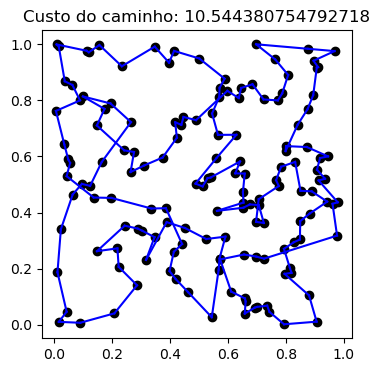

In [150]:
christofides_path = nx.algorithms.approximation.traveling_salesman.christofides(nx.from_numpy_array(GRAPH))
edges: npt.NDArray[np.int_] = np.append(np.lib.stride_tricks.sliding_window_view(christofides_path, 2), [[christofides_path[-1], christofides_path[0]]], axis=0)
christofides_path_cost: np.float_ = np.sum([GRAPH[i, j] for i, j in edges])
plot_path(nodes=NODES, path=np.array(christofides_path), path_cost=christofides_path_cost)

Podemos notar que o resultado proposta pelo algoritmo de Christofides não segue exatamente um comportamento esperado para o caminho ótimo. Naturalment,e esperaríamos que poucas ou quase nenhuma aresta se cruzasse para atingirmos um resultado próximo do exato. No entanto, o número de cruzamento de arestas ainda é bem baixo, o que mostra que o algoritmo possui sim uma boa performance. O resultado final encontrado por ele foi d eum caminho com custo aproximadamente 10.54 .

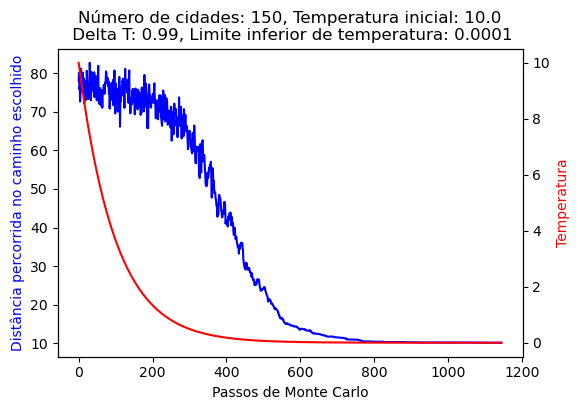

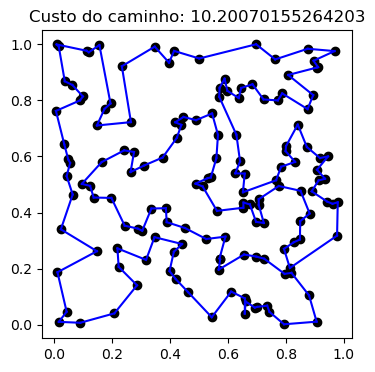

In [151]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

Já podemos notar em primeira mão que o método do Simulated Annealing, utilizando todos seus parâmetros em valores extremos, obteve um resultado melhor do que o do algoritmo de Christofides. Analisando o gráfico com uma alta temperatura e um decaimento lento, além de uma temperatura de parada bem baixa, o caixeiro pode experimentar diferentes variações de caminhos no início das iterações, e conforme realizava mais passos d eMOnte Carlo, convergiu para caminhos cada vez menores, chegando ao seu resultado final, de custo 10.2 .

Fica evidente também, com o gráfico do caminho, que esse resultado segue um padrão esperado. Nenhuma aresta se cruza em momento algum no grafo gerado, o que mostra um bom comportamento do método Simulated Annealing, uma vez que as trocas randômicas de arestas geraram bons resultados no final.

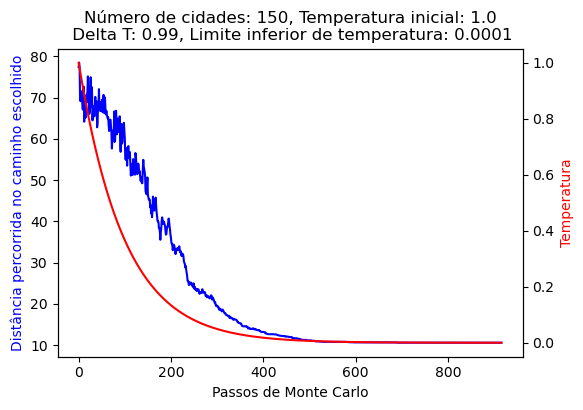

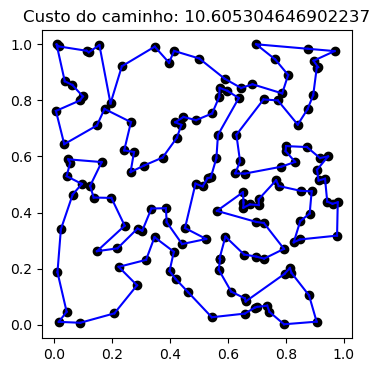

In [152]:
temperature: np.float_ = 1.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

O caso em que mantivemos um decaimento lento e uma temperatura inferior limite baixa, mas iniciamos de uma temperatura já baixa, obeteve um resultado pipor do que os dois já analisados. Issso provavelmente se deve ao fato de que, como menos passos de Monte Carlo foram realizados (já que o conjunto de temperaturas analisadas foi menor), não foi suficiente para que o caixeiro experimentasse caminhos de tamanhos e ordenações distintas. Pelo gráfico de variação da distância em função do número de passos de Monte Carlo, fica claro que, ao analisarmos o caso anterior, com uma temperatura maior, mais caminhos e distâncias são testadas.

No entanto, o resultado obtido ainda assim foi muito bom (e próximo do resultado do algoritmo de Christofides), e o caminho final gerado não parece ter cruzamento de arestas.

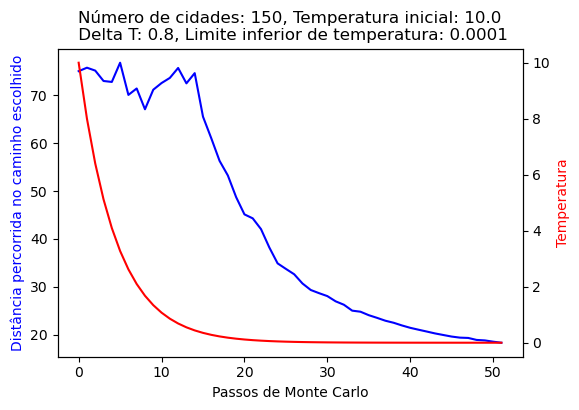

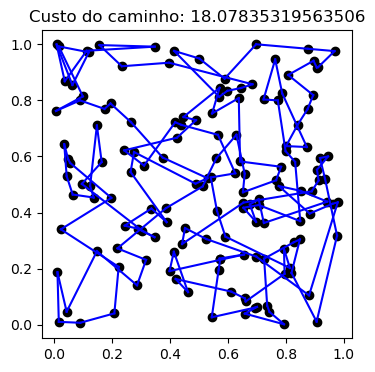

In [153]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.8
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

Neste caso, foi utilizada uma temperatura alta e um limite inferior de temperatura baixo. No etanto, utilizamos a taxa de decaimento mais rápida possível. Fica claro como isso interfere o resultado final, uma vez que notamos que apenas 50 passos de Monte Carlo foram realizados, em contrapartida com os exemplos anteriores em que foram realizados aproximadamente 1000 passos. A diferença deste cenário para os outros é muito nítida ao analisar os gráficos gerados. O espaço de caminhos/distâncias experimentados pelo caixeiro foi muito menor, uma vez que um decaimento de temperatura muito rápido limitou a quantidade de variações randômicas de caminho que o caixeiro poderia fazer.

O gráfico do caminho mostra que o custo encontrado foi de aproximadamente 18.07, quase o dobro dos resultados encontrados anteriormente. O caminho gerado também possui um número altíssimo de cruzamentos entre arestas. De maneira geral, podemos notar que valores baixos de &Delta;T ( que consequentemente geram um decaimento de temperatura muito rápido) prejudicam fortemente o método do SImulated Annealing, já que limita o espaço de soluções e força rapidamente o caixeiro a um subespaço de mínimo local que dificilmente será de boa qualidade.

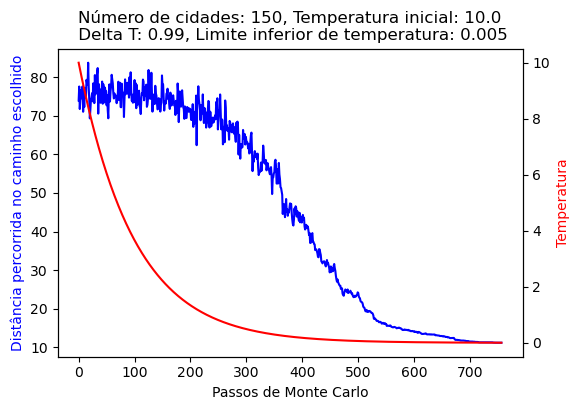

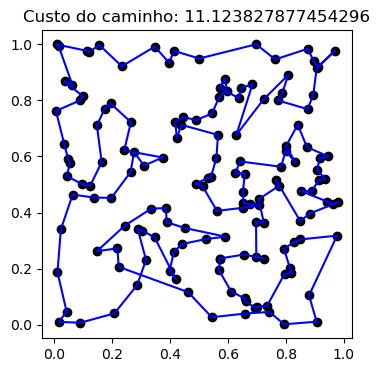

In [154]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.005

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

Neste caso, utilizamos uma taxa de decaimento da temperatura lenta, uma temperatura inicial alta, mas um limite inferior de temperatura também alto. De maneira geral, o impacto dessa variação é similar ao impacto gerado pela variação da temperatura inicial do sistema. Como o sistema para assim que alcança uma temperatura inferior ou igual ao limite inferior, o que aconteceu basicamente foi a diminuição do número de passos de Monte Carlo realizados. No entanto, essa diminuição não foi tão brusca como para o caso em que &Delta;T = 0.8, e portanto o resultado final não foi tão "desastroso". Apesar de ser um caminho mais custoso do que para todos os outros casos (exceto o pior de todos, visto anteriormente), ainda é um valor próximo dos bons obtidos.

A partir daqui, irei gerar gráficos para situações similares às geradas anteriormente, mas para tamanhos de cidades diferentes. Não irei descorrer sobre os resultados a não ser que seja algo muito fora do esperado do que já foi visto e discutido. O motivo disso é para evitar repetições e não prejudicar a visualização dessa documentação.

# NÚMERO DE CIDADES 100

In [157]:
NUMBER_OF_CITIES: np.int_ = 100
GRAPH, NODES = generate_random_graph(number_of_nodes=NUMBER_OF_CITIES)

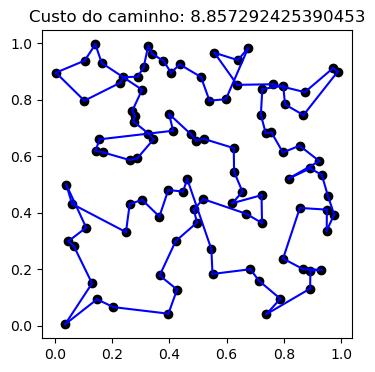

In [158]:
christofides_path = nx.algorithms.approximation.traveling_salesman.christofides(nx.from_numpy_array(GRAPH))
edges: npt.NDArray[np.int_] = np.append(np.lib.stride_tricks.sliding_window_view(christofides_path, 2), [[christofides_path[-1], christofides_path[0]]], axis=0)
christofides_path_cost: np.float_ = np.sum([GRAPH[i, j] for i, j in edges])
plot_path(nodes=NODES, path=np.array(christofides_path), path_cost=christofides_path_cost)

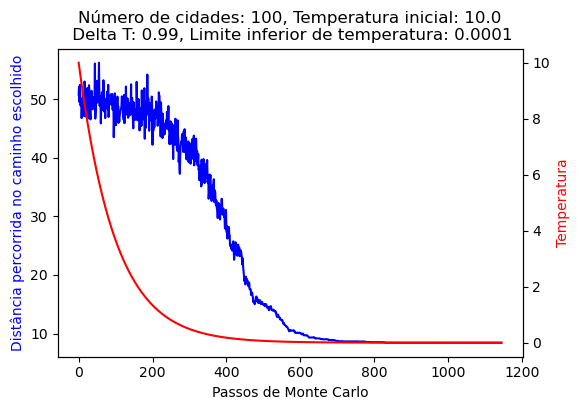

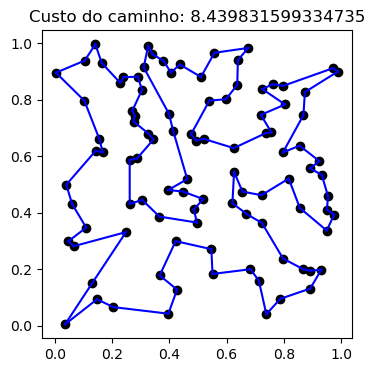

In [159]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

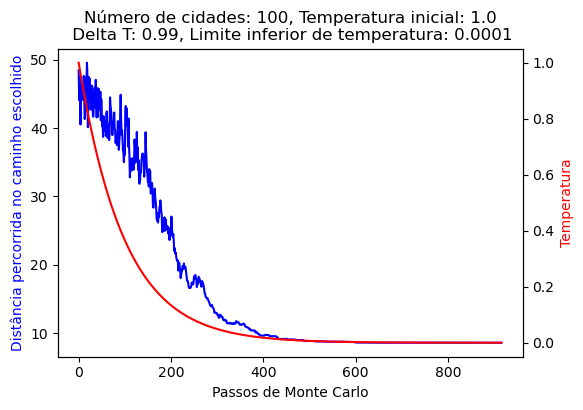

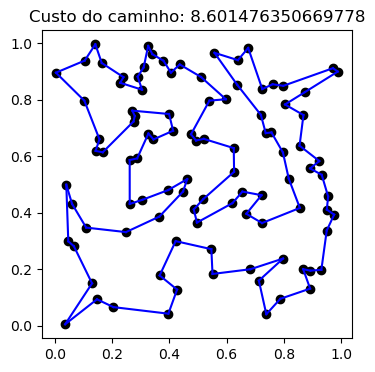

In [160]:
temperature: np.float_ = 1.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

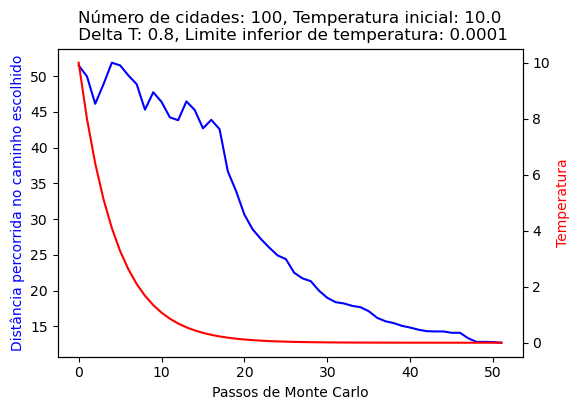

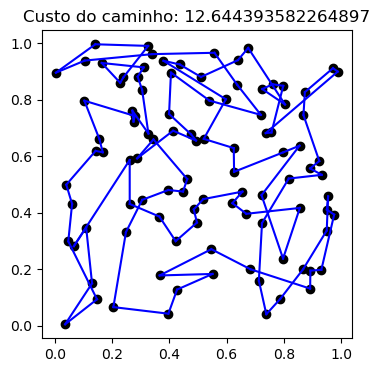

In [161]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.8
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

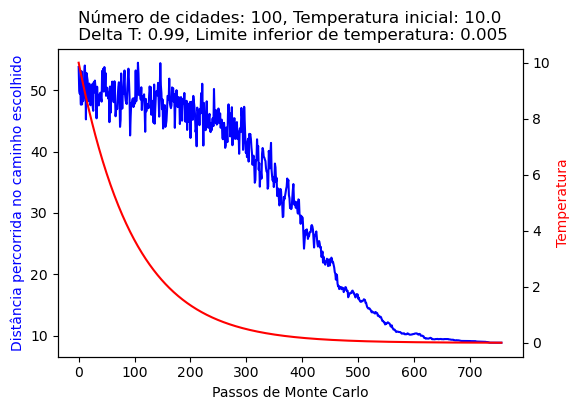

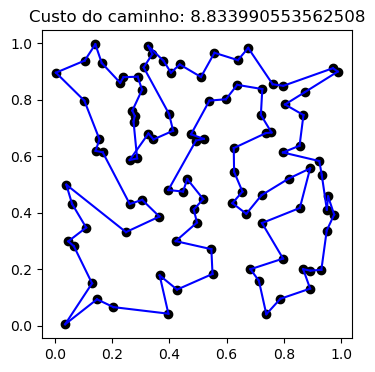

In [162]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.005

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

# NÚMERO DE CIDADES 50

In [166]:
NUMBER_OF_CITIES: np.int_ = 50
GRAPH, NODES = generate_random_graph(number_of_nodes=NUMBER_OF_CITIES)

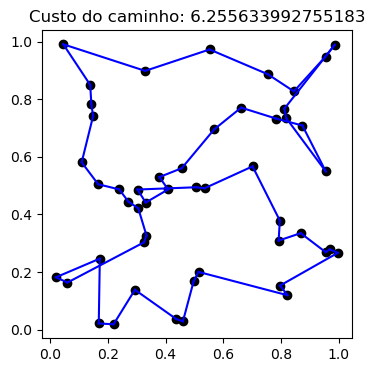

In [168]:
christofides_path = nx.algorithms.approximation.traveling_salesman.christofides(nx.from_numpy_array(GRAPH))
edges: npt.NDArray[np.int_] = np.append(np.lib.stride_tricks.sliding_window_view(christofides_path, 2), [[christofides_path[-1], christofides_path[0]]], axis=0)
christofides_path_cost: np.float_ = np.sum([GRAPH[i, j] for i, j in edges])
plot_path(nodes=NODES, path=np.array(christofides_path), path_cost=christofides_path_cost)

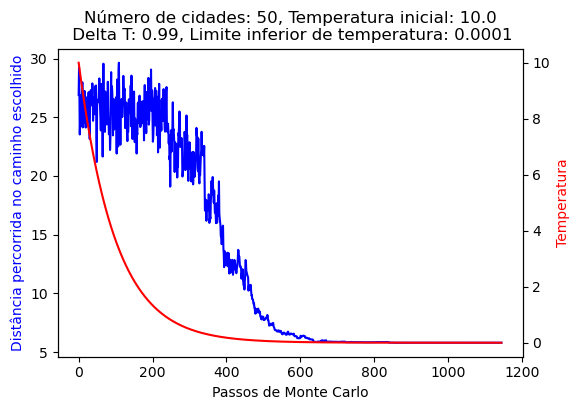

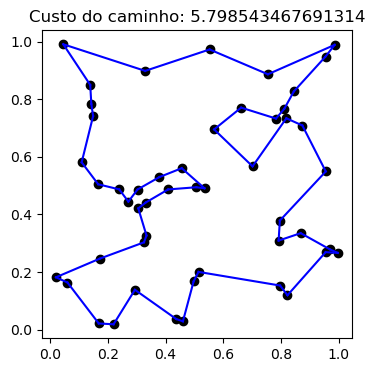

In [169]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

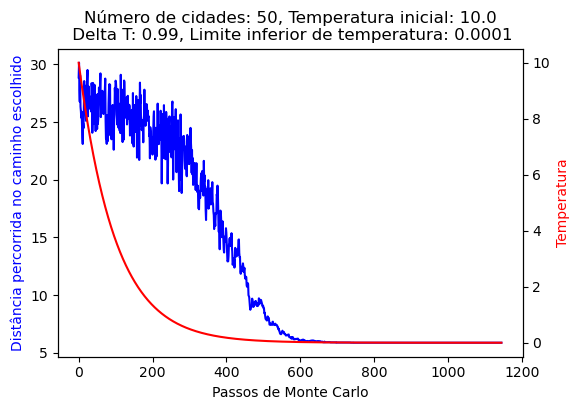

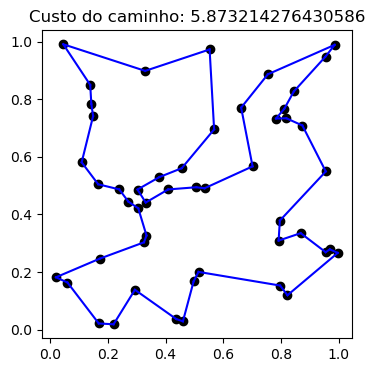

In [170]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

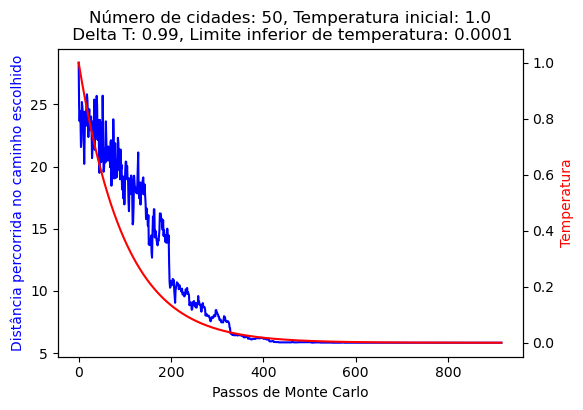

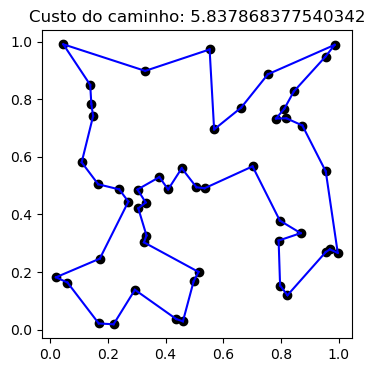

In [172]:
temperature: np.float_ = 1.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

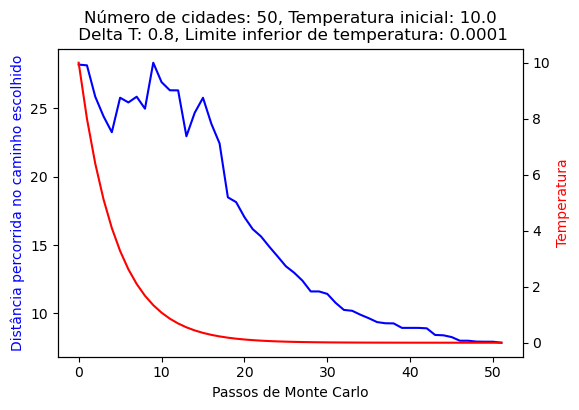

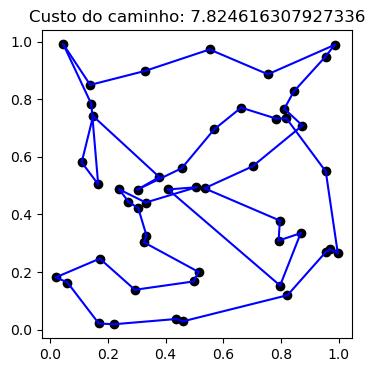

In [173]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.8
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

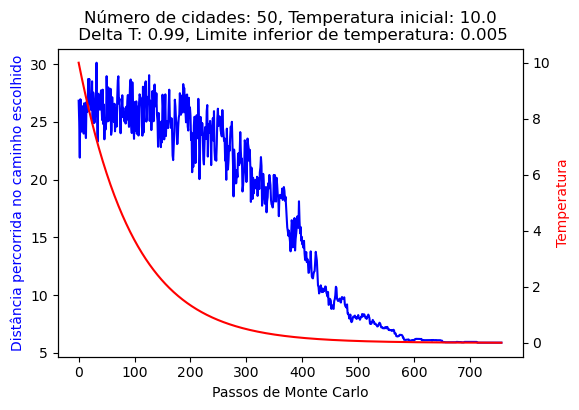

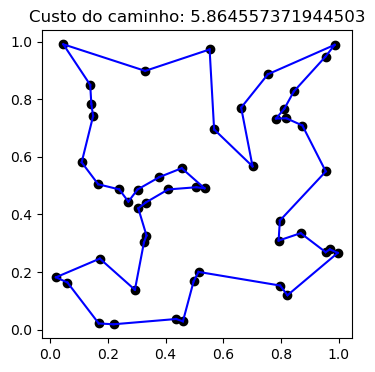

In [174]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.005

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

# NÚMERO DE CIDADES 10

In [176]:
NUMBER_OF_CITIES: np.int_ = 10
GRAPH, NODES = generate_random_graph(number_of_nodes=NUMBER_OF_CITIES)

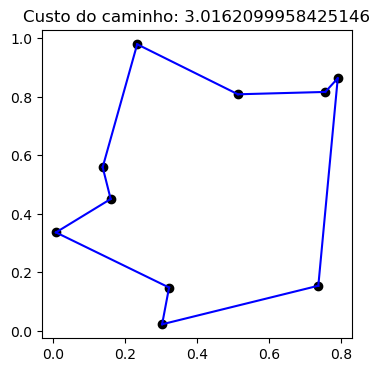

In [177]:
christofides_path = nx.algorithms.approximation.traveling_salesman.christofides(nx.from_numpy_array(GRAPH))
edges: npt.NDArray[np.int_] = np.append(np.lib.stride_tricks.sliding_window_view(christofides_path, 2), [[christofides_path[-1], christofides_path[0]]], axis=0)
christofides_path_cost: np.float_ = np.sum([GRAPH[i, j] for i, j in edges])
plot_path(nodes=NODES, path=np.array(christofides_path), path_cost=christofides_path_cost)

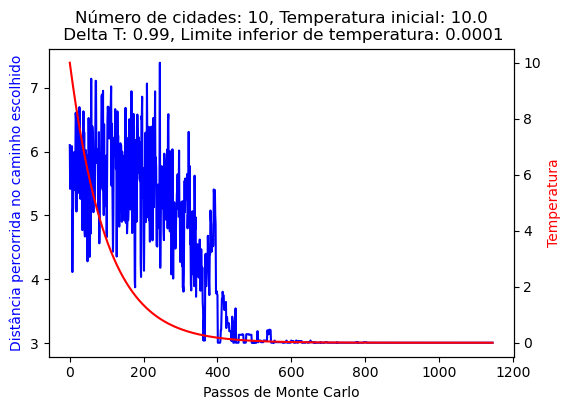

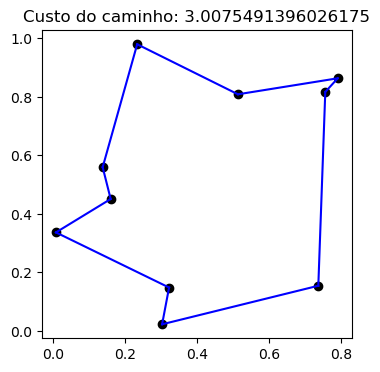

In [178]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

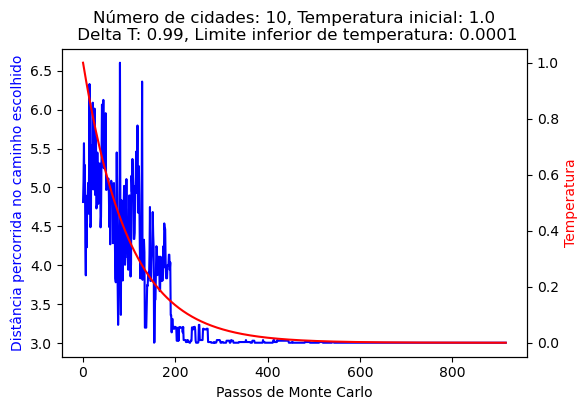

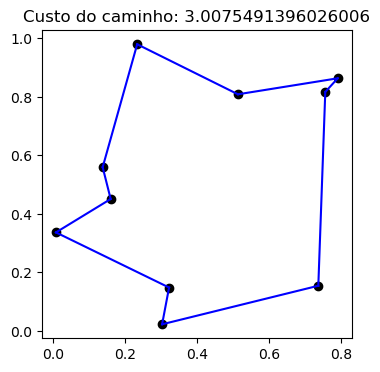

In [179]:
temperature: np.float_ = 1.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

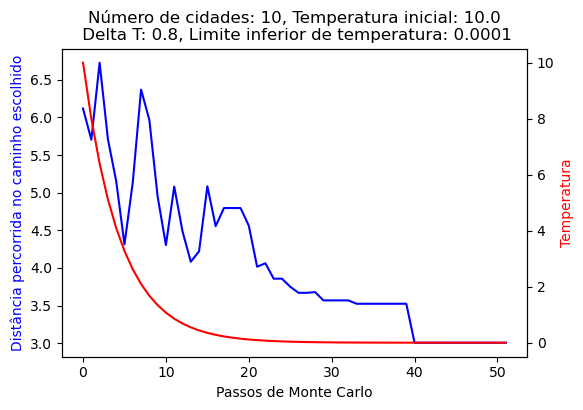

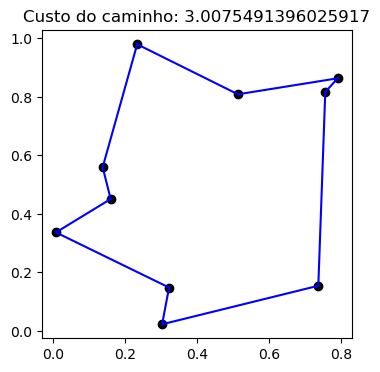

In [180]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.80
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

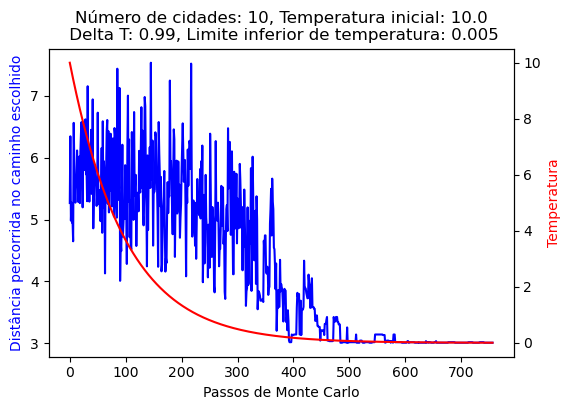

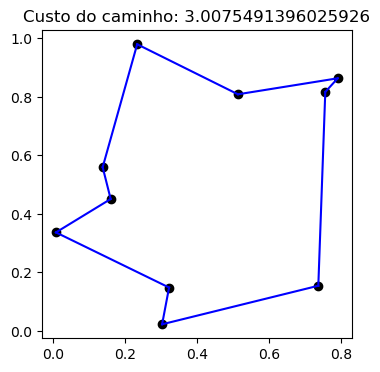

In [181]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.005

path, path_cost, nodes, distances, temperatures = tsp(graph=GRAPH, nodes=NODES, temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

Para o caso de 10 cidades, é interessante enxergar como o resultado ótimo é encontrado pelo método em todos os casos. Issso se deve ao fato de que o número de cidades é muito baixo, permitindo que o modelo possa conervgir rapidamente para o mínimo global.

Em resumo, essa tonelada de gráficos gerados em relação ao modelo nos permite fazer algumas inferências em relação a como o Simulated Annealing performa na computação do problema do caixeiro viajante. Uma coisa que ficou nítida é o impacto do valor de &Delta;T para o sistema. Caso um valor muito alto seja escolhido, o caixeiro terá tempo e irá realizar uma grande quantidade de passsos de MOnte Carlo, uma vez que sua convergẽncia para um valor de temperatura menor do que o limite inferior irá demorar muito mais. Com esse espaço de busca muito maior, as chances do caixeiro sair de subespaços de mínimos locais ruins é muito maior, o que permite que o resultado final seja extremamente satisfatório, muitas vezes até superando o resultado obtido por método determinísticos como o algoritmo de Christofides. Em contrapartida, com um valor baixo de &Delta;T, o caixeiro possui um espaço de busca extremamente pequeno e realiza uma quantidade baixíssima de passos de Monte Carlo, já que a temperatura converge rapidamente para valores menores do que o da temperatura inferior limite. Dessa maneira, o caixeiro fica preso em um subespaço de mínimo global e o resultado final obtido dificilmente será de boa qualidade.